# Gene Expression variance analysis

## 1. Load and summarize cis-variance predictions from FlashZoi

In [34]:
# Setup
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
from tabulate import tabulate
import os
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression

variants_scored_dir = "../data/output/dataset1/flashzoi_outputs/variants_scored"
cache_file = "../data/intermediate/flashzoi_gene_stats.tsv"

gtex_expr_file = "../data/initial/GTEx_Analysis_2022-06-06_v10_RNASeQCv2.4.2_gene_median_tpm.gct"
gtex_filtered_genes = "../data/intermediate/GTEx_chr20_mane_TPM.tsv"

gtex_sample_expr_file = "../data/initial/GTEx_Analysis_v10_RNASeQCv2.4.2_gene_tpm.gct.gz"
sample_annot_file = "../data/initial/GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt"


In [13]:
if os.path.exists(cache_file):
    var_df = pd.read_csv(cache_file, sep="\t")
    print(f"Loaded cached gene summary table: {cache_file}")
else:
    records = []
    for folder in glob.glob(os.path.join(variants_scored_dir, "*")):
        gene_id = os.path.basename(folder)
        var_file = os.path.join(folder, f"{gene_id}_variants.tsv")
        if not os.path.isfile(var_file):
            continue
        df = pd.read_csv(var_file, sep="\t")
        df.columns = df.columns.str.upper()
        if df.empty or not {"VAR_I", "AF", "DELTA"}.issubset(df.columns):
            continue
        records.append({
            "gene_id": gene_id,
            "predicted_cis_variance": df["VAR_I"].sum(),
            "num_snps": len(df),
            "mean_AF": df["AF"].mean(),
            "median_AF": df["AF"].median(),
            "mean_DELTA": df["DELTA"].mean(),
            "median_DELTA": df["DELTA"].median(),
            "mean_VAR_I": df["VAR_I"].mean(),
            "median_VAR_I": df["VAR_I"].median()
        })
    var_df = pd.DataFrame(records)
    var_df.to_csv(cache_file, sep="\t", index=False)
    print(f"Saved gene summary to: {cache_file}")

print(var_df.shape)
print(var_df.head())

Loaded cached gene summary table: ../data/intermediate/flashzoi_gene_stats.tsv
(15, 9)
           gene_id  predicted_cis_variance  num_snps   mean_AF  median_AF  \
0  ENSG00000131061              197.062469     11727  0.025363   0.000512   
1  ENSG00000197122              238.118638     12399  0.038575   0.000527   
2  ENSG00000196839              260.276776     11522  0.030893   0.000519   
3  ENSG00000170191              184.422547     13106  0.034233   0.000565   
4  ENSG00000101333              129.060822     10818  0.043196   0.000598   

   mean_DELTA  median_DELTA  mean_VAR_I  median_VAR_I  
0   -0.793469     -0.793469    0.016804      0.000644  
1   -0.770944     -0.770944    0.019205      0.000617  
2   -0.842143     -0.842143    0.022590      0.000735  
3   -0.604251     -0.604251    0.014072      0.000412  
4   -0.501769     -0.501769    0.011930      0.000301  


1. Cis Variance (VAR_I sum):
- Shows the total predicted variability in expression caused by common SNPs near each gene
- Higher values suggest a gene’s expression is more sensitive to naturally occurring genetic variation
2. Number of SNPs (num_snps):
- genes have about 10,000 to 13,000 SNPs per gene window (±262 kb).
- Should continue from here exploring variance, it's probably not only driven by SNP count
3. Allele Frequency (mean_AF, median_AF):
- Mean AF is around 2.5–4%, while median AF is very low (~0.05%) → implies the variant effect distribution is skewed toward rare variants
- These rare variants may disproportionately contribute to variance through large Δ values.
4. Regulatory Effect (mean_DELTA, median_DELTA):
- Meann and median Δ are consistently strongly negative, indicating the typical variant is predicted to reduce expression (in log fold-change units).
5. per-Variant Effect (mean_VAR_I, median_VAR_I):
- average per-SNP contribution to variance is around 0.012–0.022, but median is much lower
- few high-impact SNPs dominate the predicted variance per gene.

## 2. Distribution overview of gene-level predicted variance

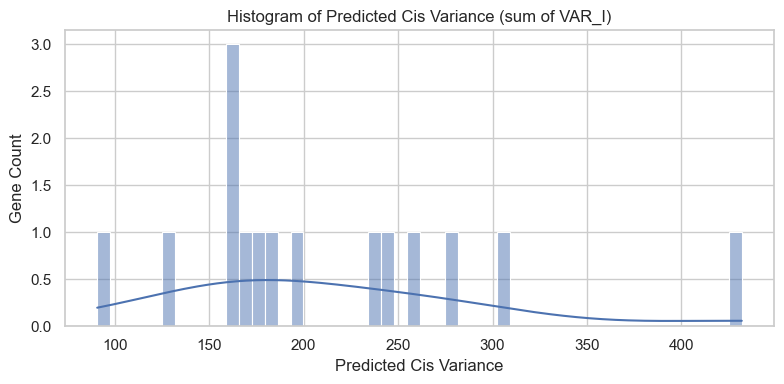

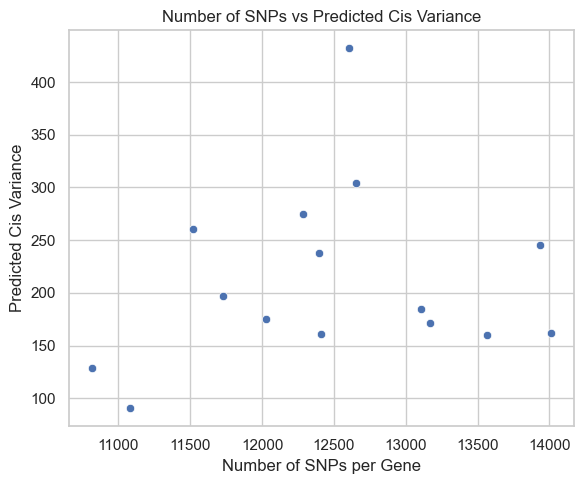

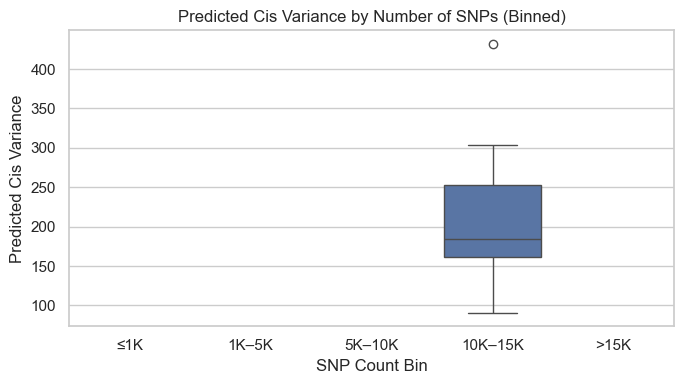

In [14]:
sns.set_theme(style="whitegrid")

# 1. Total predicted cis variance per gene
plt.figure(figsize=(8, 4))
sns.histplot(var_df["predicted_cis_variance"], bins=50, kde=True)
plt.title("Histogram of Predicted Cis Variance (sum of VAR_I)")
plt.xlabel("Predicted Cis Variance")
plt.ylabel("Gene Count")
plt.tight_layout()
plt.show()


# 2. SNP count vs predicted cis variance
plt.figure(figsize=(6, 5))
sns.scatterplot(data=var_df, x="num_snps", y="predicted_cis_variance")
plt.title("Number of SNPs vs Predicted Cis Variance")
plt.xlabel("Number of SNPs per Gene")
plt.ylabel("Predicted Cis Variance")
plt.tight_layout()
plt.show()

# 3. cis variance binned by SNP count
# Define SNP bins
var_df["snp_bin"] = pd.cut(
    var_df["num_snps"],
    bins=[0, 1000, 5000, 10000, 15000, 20000],
    labels=["≤1K", "1K–5K", "5K–10K", "10K–15K", ">15K"]
)

plt.figure(figsize=(7, 4))
sns.boxplot(data=var_df, x="snp_bin", y="predicted_cis_variance")
plt.title("Predicted Cis Variance by Number of SNPs (Binned)")
plt.xlabel("SNP Count Bin")
plt.ylabel("Predicted Cis Variance")
plt.tight_layout()
plt.show()

1. Histogram of Predicted Cis Variance
- Most genes have predicted cis variance between 150–300
- The tail shows a few genes with very high variance. maybe it is due to high delta SNPs or rare/common variants with large effect
2. SNP Count vs Cis Variance
- nothing obvious comes out from here
3. Predicted Cis Variance by SNP Count Bin
- All genes fall into the 10K–15K SNP bin, probably due to similar ±262kb window size or similar density on chr20(?), but variance is still highly variable

## 3. Correlation exploring

,X,Y,Pearson_r,Pearson_p,Spearman_r,Spearman_p
0,num_snps,predicted_cis_variance,0.169,0.548,0.121,0.666
1,mean_AF,predicted_cis_variance,-0.005,0.986,-0.246,0.376
2,mean_DELTA,predicted_cis_variance,-0.818,0.000,-0.864,0.000
3,log_num_snps,log_cis_var,0.282,0.308,0.121,0.666


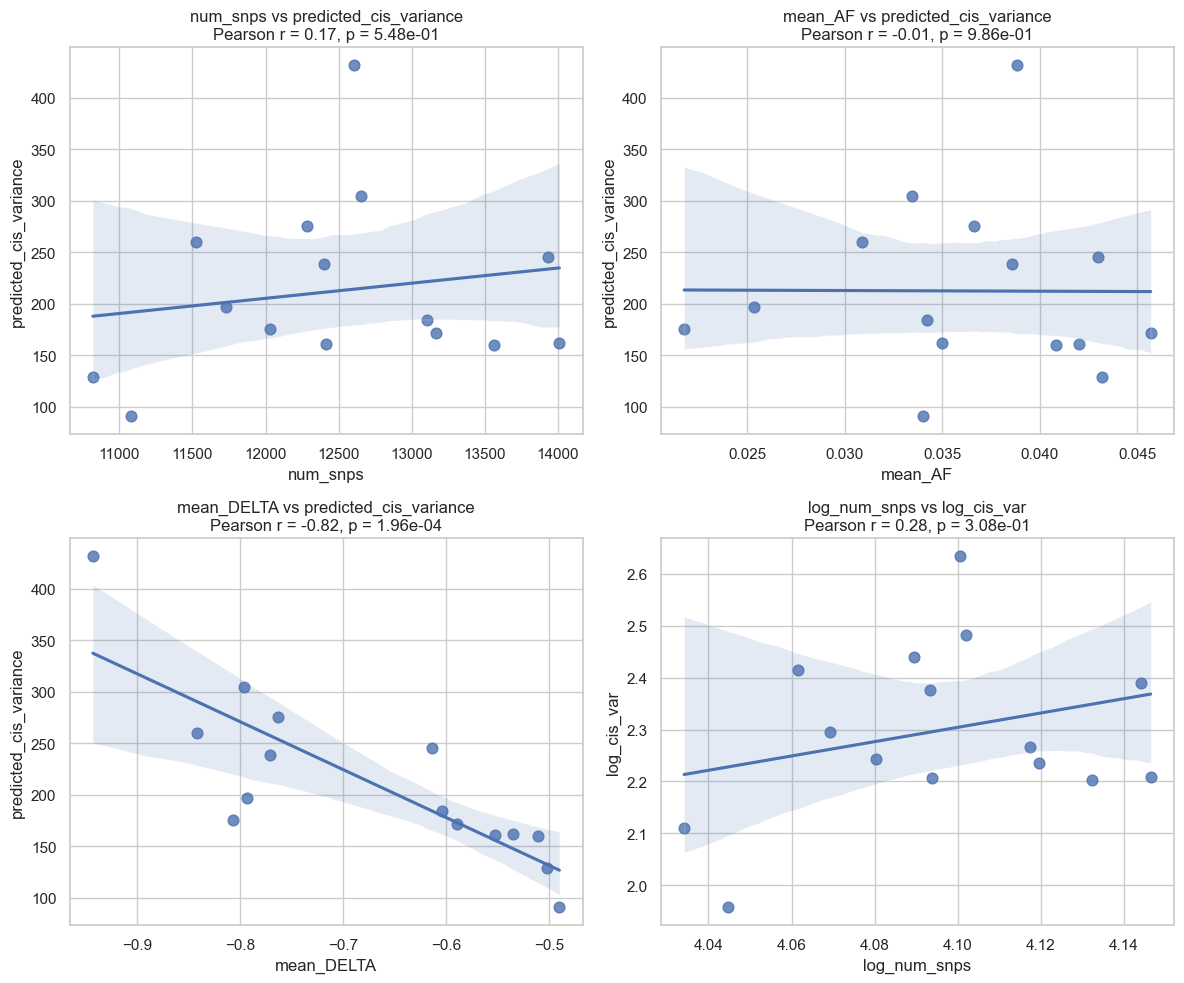

In [15]:
var_df["log_cis_var"] = np.log10(var_df["predicted_cis_variance"] + 1e-6) #TODO: should this be log 10 or log 2?
var_df["log_num_snps"] = np.log10(var_df["num_snps"] + 1e-6) #TODO: should this be log 10 or log 2?

# relevcant correlations
correlations = [
    ("num_snps", "predicted_cis_variance"),
    ("mean_AF", "predicted_cis_variance"),
    ("mean_DELTA", "predicted_cis_variance"),
    ("log_num_snps", "log_cis_var")
]

# compute correlation stats
corr_table = []
for x, y in correlations:
    pearson_r, p_p = pearsonr(var_df[x], var_df[y])
    spearman_r, p_s = spearmanr(var_df[x], var_df[y])
    corr_table.append({
        "X": x,
        "Y": y,
        "Pearson_r": pearson_r,
        "Pearson_p": p_p,
        "Spearman_r": spearman_r,
        "Spearman_p": p_s
    })
corr_df = pd.DataFrame(corr_table)

#print(tabulate(corr_df, headers="keys", tablefmt="github", floatfmt=".3f"))

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

for i, (x, y) in enumerate(correlations):
    sns.regplot(data=var_df, x=x, y=y, ax=axs[i], scatter_kws={"s": 60, "alpha": 0.8})
    r, p = pearsonr(var_df[x], var_df[y])
    axs[i].set_title(f"{x} vs {y}\nPearson r = {r:.2f}, p = {p:.2e}")
    axs[i].set_xlabel(x)
    axs[i].set_ylabel(y)

plt.tight_layout()

corr_df.style.set_caption("Correlation table").format(precision=3)

- Maybe our SNP count is not enough to explain cis-genetic variance. Two genes with the same number of variants may differ 3× in variance, depending on Δ and AF.
- Δ magnitude (effect size) is the main driver of expression variability — consistent with what we would expect from a variance formula
var_i = Delta_i^2 * 2AF(1-AF)

### 3.1 Correlation matrix

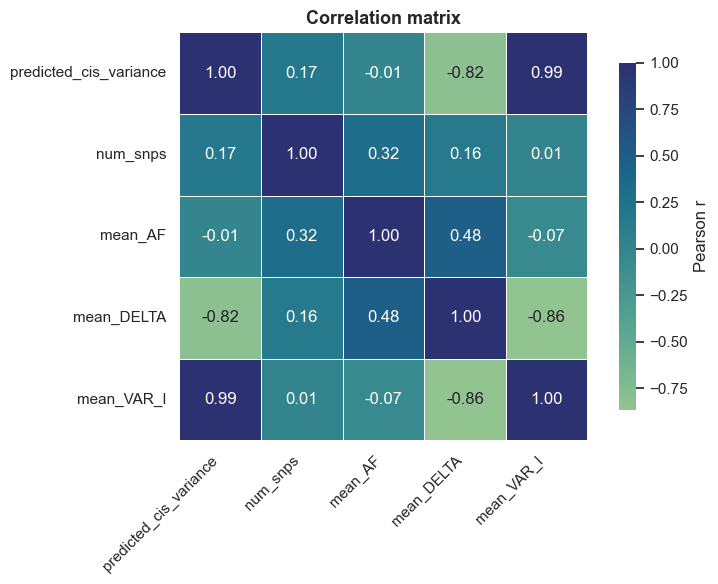

In [16]:
core_cols = [
    "predicted_cis_variance",
    "num_snps",
    "mean_AF",
    "mean_DELTA",
    "mean_VAR_I"
]

corr_matrix = var_df[core_cols].corr(method="pearson")

# Plot
plt.figure(figsize=(8, 6))
sns.set_theme(style="white")
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="crest",
    center=0,
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.85, "label": "Pearson r"}
)

plt.title("Correlation matrix", fontsize=13, weight="bold")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 3.2 Partial correlation Analysis


Partial Correlation Summary Table:

            X        Y   Control  Partial_Pearson_r  Partial_Pearson_p
0     mean_AF  cis_var  num_snps             -0.063              0.824
1  mean_DELTA  cis_var  num_snps             -0.867              0.000


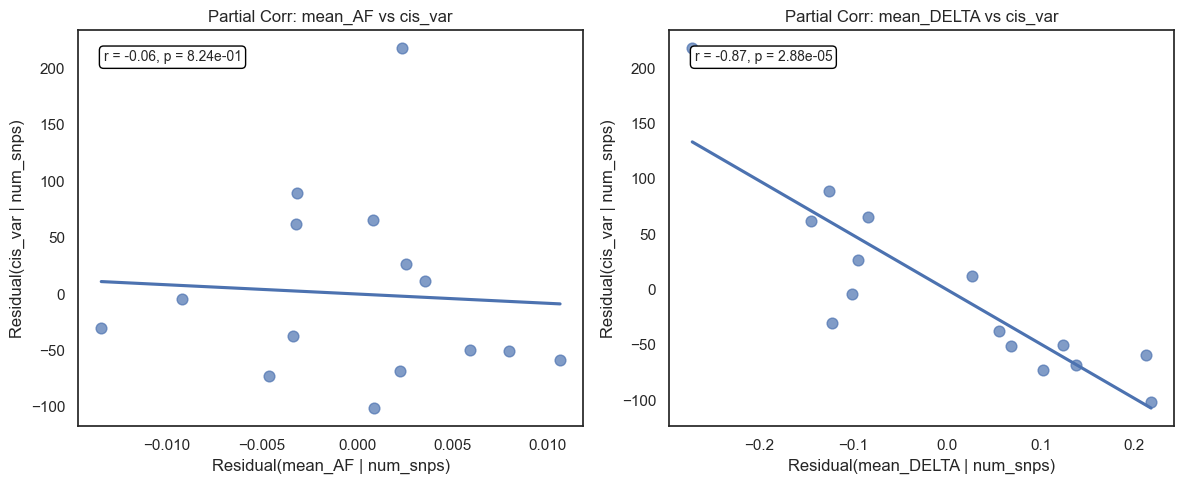

In [17]:
var_df["cis_var"] = var_df["predicted_cis_variance"]

# Partial correlation function
def partial_corr(x, y, control, method="pearson"):
    X = sm.add_constant(control)
    model_x = sm.OLS(x, X).fit()
    model_y = sm.OLS(y, X).fit()
    resid_x = model_x.resid
    resid_y = model_y.resid
    if method == "pearson":
        r, p = pearsonr(resid_x, resid_y)
    elif method == "spearman":
        r, p = spearmanr(resid_x, resid_y)
    else:
        raise ValueError("method must be 'pearson' or 'spearman'")
    return r, p, resid_x, resid_y

# Run two comparisons
results = []
comparisons = [
    ("mean_AF", "Partial Corr: mean_AF vs cis_var"),
    ("mean_DELTA", "Partial Corr: mean_DELTA vs cis_var")
]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for i, (feature, title) in enumerate(comparisons):
    x = var_df["cis_var"]
    y = var_df[feature]
    z = var_df["num_snps"]
    r, p, res_x, res_y = partial_corr(x, y, z)
    results.append({
        "X": feature,
        "Y": "cis_var",
        "Control": "num_snps",
        "Partial_Pearson_r": r,
        "Partial_Pearson_p": p
    })
    sns.regplot(x=res_y, y=res_x, ci=None, scatter_kws={"s": 60, "alpha": 0.7}, ax=axs[i])
    axs[i].set_xlabel(f"Residual({feature} | num_snps)")
    axs[i].set_ylabel("Residual(cis_var | num_snps)")
    axs[i].set_title(title)
    axs[i].annotate(
        f"r = {r:.2f}, p = {p:.2e}",
        xy=(0.05, 0.95), xycoords="axes fraction",
        ha="left", va="top", fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
    )

plt.tight_layout()

# Output summary table using pandas
partial_corr_df = pd.DataFrame(results)
print("\nPartial Correlation Summary Table:\n")
print(partial_corr_df.round(3))

- After removing the effect of num_snps, mean allele frequency has no remaining relationship to predicted cis-variance, so variant freq alone doesn’t explain expression variability — their contribution to cis-variance depends on effect size

- After accounting for num_snps, the strength of predicted regulatory effect (delta) is highly predictive of cis-variance. The more negative the average Δ across SNPs near a gene, the larger the predicted variance in expression.

## 4. Tissue-level gene prioritization

In [21]:
# Load pre-filtered gene list based on GTEx percentiles and chr20 MANE genes

# 1. Load and fix gene_base column
moderately_expressed_genes = pd.read_csv(gtex_filtered_genes, sep="\t")
moderately_expressed_genes["gene_base"] = moderately_expressed_genes["gene_id"].str.split(".").str[0]
moderately_expressed_genes = moderately_expressed_genes.set_index("gene_base")

print(f"Loaded {len(moderately_expressed_genes)} pre-filtered GTEx muscle-expressed chr20 genes")
valid_genes = set(moderately_expressed_genes.index)

Loaded 272 pre-filtered GTEx muscle-expressed chr20 genes


In [22]:
if os.path.exists(cache_file):
    var_df = pd.read_csv(cache_file, sep="\t")
    print(f"Loaded cached gene summary table: {cache_file}")
else:
    records = []
    for folder in glob.glob(os.path.join(variants_scored_dir, "*")):
        gene_id = os.path.basename(folder)
        if gene_id not in valid_genes:
            continue

        var_file = os.path.join(folder, f"{gene_id}_variants.tsv")
        if not os.path.isfile(var_file):
            continue
        df = pd.read_csv(var_file, sep="\t")
        df.columns = df.columns.str.upper()

        # Quality check
        if df.empty or not {"VAR_I", "AF", "DELTA"}.issubset(df.columns):
            continue

        records.append({
            "gene_id": gene_id,
            "predicted_cis_variance": df["VAR_I"].sum(),
            "num_snps": len(df),
            "mean_AF": df["AF"].mean(),
            "median_AF": df["AF"].median(),
            "mean_DELTA": df["DELTA"].mean(),
            "median_DELTA": df["DELTA"].median(),
            "mean_VAR_I": df["VAR_I"].mean(),
            "median_VAR_I": df["VAR_I"].median()
        })

    var_df = pd.DataFrame(records)
    var_df.to_csv(cache_file, sep="\t", index=False)
    print(f"Saved gene summary to: {cache_file}")

print(var_df.shape)
print(var_df.head())

Loaded cached gene summary table: ../data/intermediate/flashzoi_gene_stats.tsv
(15, 9)
           gene_id  predicted_cis_variance  num_snps   mean_AF  median_AF  \
0  ENSG00000131061              197.062469     11727  0.025363   0.000512   
1  ENSG00000197122              238.118638     12399  0.038575   0.000527   
2  ENSG00000196839              260.276776     11522  0.030893   0.000519   
3  ENSG00000170191              184.422547     13106  0.034233   0.000565   
4  ENSG00000101333              129.060822     10818  0.043196   0.000598   

   mean_DELTA  median_DELTA  mean_VAR_I  median_VAR_I  
0   -0.793469     -0.793469    0.016804      0.000644  
1   -0.770944     -0.770944    0.019205      0.000617  
2   -0.842143     -0.842143    0.022590      0.000735  
3   -0.604251     -0.604251    0.014072      0.000412  
4   -0.501769     -0.501769    0.011930      0.000301  


#

### Merge var_df with filtered expression (TPM) values

In [43]:
merged = var_df.merge(
    moderately_expressed_genes[["TPM", "pct"]],  # pct = GTEx percentile
    left_on="gene_id", right_index=True, how="left"
)

# Sanity check
assert merged["TPM"].notna().all(), "Some TPM values missing after merge"

# compute per-SNP variance
merged["variance_per_snp"] = merged["predicted_cis_variance"] / merged["num_snps"]

print(merged[["gene_id", "TPM", "pct", "predicted_cis_variance", "variance_per_snp"]].head())

           gene_id      TPM       pct  predicted_cis_variance  \
0  ENSG00000131061  2.80078  0.838141              197.062469   
1  ENSG00000197122  1.20538  0.795216              238.118638   
2  ENSG00000196839  3.49567  0.849135              260.276776   
3  ENSG00000170191  1.49749  0.806464              184.422547   
4  ENSG00000101333  1.23113  0.796199              129.060822   

   variance_per_snp  
0          0.016804  
1          0.019205  
2          0.022590  
3          0.014072  
4          0.011930  


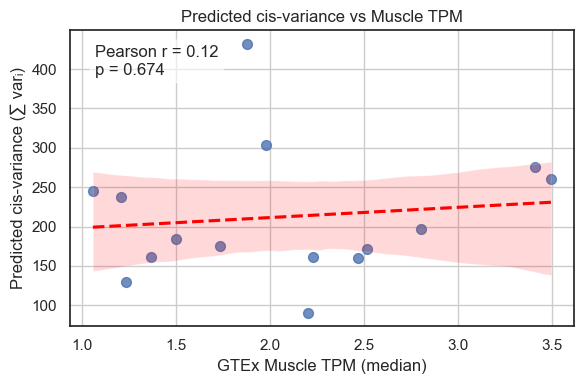

In [44]:
x = merged["TPM"]
y = merged["predicted_cis_variance"]

# Pearson correlation
r, p = pearsonr(x, y)

plt.figure(figsize=(6, 4))
sns.regplot(x=x, y=y, scatter_kws={'s': 50}, line_kws={"color": "red", "linestyle": "--"})

plt.text(
    0.05, 0.95,
    f"Pearson r = {r:.2f}\np = {p:.3g}",
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.6)
)

plt.title("Predicted cis-variance vs Muscle TPM")
plt.xlabel("GTEx Muscle TPM (median)")
plt.ylabel("Predicted cis-variance (∑ varᵢ)")
plt.grid(True)
plt.tight_layout()
plt.show()

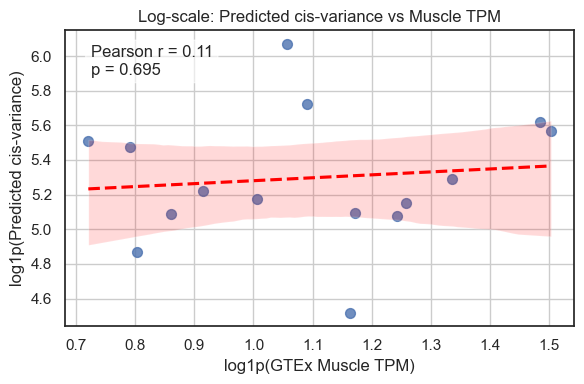

In [45]:
# compute log-transformed values
x = np.log1p(merged["TPM"])
y = np.log1p(merged["predicted_cis_variance"])

# compute Pearson correlation on log values
r, p = pearsonr(x, y)

plt.figure(figsize=(6, 4))
sns.regplot(x=x, y=y, scatter_kws={'s': 50}, line_kws={"color": "red", "linestyle": "--"})

plt.text(
    0.05, 0.95, f"Pearson r = {r:.2f}\np = {p:.3g}",
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.6)
)

plt.title("Log-scale: Predicted cis-variance vs Muscle TPM")
plt.xlabel("log1p(GTEx Muscle TPM)")
plt.ylabel("log1p(Predicted cis-variance)")
plt.grid(True)
plt.tight_layout()
plt.show()

## 5. Recalibartion

Using Philipp's R dataset containing VG estimates for genes based on haplotype allelic expression (ANEVA-H). We extract here the column "MSCLSK" for skeletal muscle.

VG_Muscle is a per-gene measure of population-level cis-regulatory expression variance (GTEx v8)

Then we are using our previous filtered genes from GTEx muscle expression within the 70–95th percentile to remove outliers (too low/highly expressed).



In [10]:
os.environ["R_HOME"] = "/Library/Frameworks/R.framework/Resources"
robjects.r['load']("../data/initial/vg_hi.rda")
vg_df = pandas2ri.rpy2py(robjects.r['vg_hi'])

# processing only for Muscle tissue ("MSCLSK")
vg_df = vg_df.reset_index().rename(columns={"index": "gene_id", "MSCLSK": "VG_Muscle"})
vg_df = vg_df[["gene_id", "VG_Muscle"]].dropna()

print(vg_df.head())

           gene_id  VG_Muscle
0  ENSG00000227232   0.684911
1  ENSG00000268903   1.221687
2  ENSG00000279457   0.456051
3  ENSG00000230021   0.893867
4  ENSG00000237973   0.893867


In [46]:
moderately_expressed_genes = pd.read_csv(gtex_filtered_genes, sep="\t")
moderately_expressed_genes["gene_base"] = moderately_expressed_genes["gene_id"].str.split(".").str[0]
moderately_expressed_genes = moderately_expressed_genes.set_index("gene_base")

merged = var_df.merge(
    moderately_expressed_genes[["TPM", "pct"]],
    left_on="gene_id", right_index=True, how="left"
)

assert merged["TPM"].notna().all(), "Some TPM values missing after merge"

# compute per-SNP variance
merged["variance_per_snp"] = merged["predicted_cis_variance"] / merged["num_snps"]

print(merged[["gene_id", "TPM", "pct", "predicted_cis_variance", "variance_per_snp"]].head())

           gene_id      TPM       pct  predicted_cis_variance  \
0  ENSG00000131061  2.80078  0.838141              197.062469   
1  ENSG00000197122  1.20538  0.795216              238.118638   
2  ENSG00000196839  3.49567  0.849135              260.276776   
3  ENSG00000170191  1.49749  0.806464              184.422547   
4  ENSG00000101333  1.23113  0.796199              129.060822   

   variance_per_snp  
0          0.016804  
1          0.019205  
2          0.022590  
3          0.014072  
4          0.011930  


Mathced our Flaszhoi × AF predicted cis-variance per gene with GTEx expression data

### Comparing a Flashzoi-based in silico prediction with a population derived data for expression variability

In [47]:
vg_df["gene_base"] = vg_df["gene_id"].str.split(".").str[0]

# merge VG into the main table
merged_vg = merged.merge(
    vg_df[["gene_base", "VG_Muscle"]],
    left_on="gene_id", right_on="gene_base", how="inner"
)
merged_vg.head()

print(merged_vg[["gene_id", "predicted_cis_variance", "VG_Muscle"]].head())

           gene_id  predicted_cis_variance  VG_Muscle
0  ENSG00000131061              197.062469   0.007140
1  ENSG00000197122              238.118638   0.029678
2  ENSG00000196839              260.276776   0.012538
3  ENSG00000170191              184.422547   0.014181
4  ENSG00000101333              129.060822   0.011003


### Rank Correlation Between Predictions and Observed VG

checking whether our predicted gene-level variances can correctly order genes by real world variability (VG)

In [37]:
rho, pval = spearmanr(
    merged_vg["predicted_cis_variance"],
    merged_vg["VG_Muscle"]
)

print(f"Spearman ρ = {rho:.3f}, p = {pval:.2e}")

Spearman ρ = 0.018, p = 9.50e-01


no rank correlation:(

### Fit Linear Model: VG ≈ α × predicted + b

In [48]:
X = merged_vg["predicted_cis_variance"].values.reshape(-1, 1)
y = merged_vg["VG_Muscle"].values

reg = LinearRegression().fit(X, y)
alpha = reg.coef_[0]
intercept = reg.intercept_

print(f"Fitted model: VG ≈ {alpha:.3f} × predicted + {intercept:.3f}")

Fitted model: VG ≈ -0.000 × predicted + 0.028


### Rescale Predictions

In [39]:
# TODO: rescaling each Δ by √𝛼 (± intercept) ?

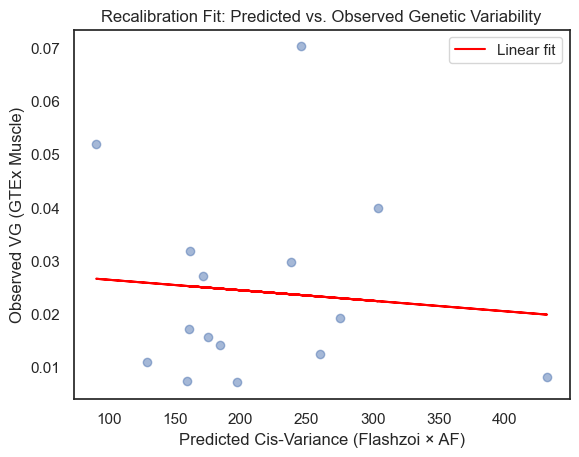

In [49]:
import matplotlib.pyplot as plt

plt.scatter(merged_vg["predicted_cis_variance"], merged_vg["VG_Muscle"], alpha=0.5)
plt.plot(X, reg.predict(X), color="red", label="Linear fit")
plt.xlabel("Predicted Cis-Variance (Flashzoi × AF)")
plt.ylabel("Observed VG (GTEx Muscle)")
plt.title("Recalibration Fit: Predicted vs. Observed Genetic Variability")
plt.legend()
plt.show()